## Reinforcement Learning Schach
Im Folgenden wird das Notebook https://www.kaggle.com/code/arjanso/reinforcement-learning-chess-3-q-networks mit Hyperparamtertuning angepasst und optimiert.



###  Q-Netzwerke
In diesem Notizbuch trainieren wir einen Agenten auf eine vereinfachte Version von Schach, die "Capture Chess" genannt wird. In dieser Umgebung wird der Agent, der die weißen Steine spielt, dafür belohnt, Figuren zu schlagen und nicht wie sonst ein Schachmatt. Dies wird aus Komplexitätsgründen so gehandhabt. Nach dem Ausführen dieses Notebooks erhalten wir einen Agenten, der gegen einen zufälligen Gegner Figuren schlagen kann, wie in der untenstehenden GIF-Animation dargestellt.

![](https://github.com/antoine-fuchs/ReinforcementLearning/blob/main/Chess_Gif.gif)



#### Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect

In [3]:
!pip install keras==2.4.0

  Using cached Keras-2.4.0-py2.py3-none-any.whl (170 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
  Using cached tensorflow-2.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
  Using cached tensorflow-2.11.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached tensorflow-2.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached tensorflow-2.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
  Using cached tensorflow-2.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.8 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
INFO: pip is lo

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
### Lade die verschiednen Files, um Änderungen vornehmen zu können

In [7]:
!cp /content/gdrive/MyDrive/RL/agent.py .
!cp /content/gdrive/MyDrive/RL/learn.py .
!cp /content/gdrive/MyDrive/RL/run.py .
!cp /content/gdrive/MyDrive/RL/environment.py .
!cp /content/gdrive/MyDrive/RL/__init__.py .



In [8]:
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package

  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-wgi48l1e
  Running command git clone --filter=blob:none --quiet https://github.com/arjangroen/RLC.git /tmp/pip-req-build-wgi48l1e
  Resolved https://github.com/arjangroen/RLC.git to commit e54eb7380875f64fd06106c59aa376b426d9e5ca
  Preparing metadata (setup.py) ... done


In [9]:
import chess
from chess.pgn import Game
import RLC
from agent import Agent
from learn import Q_learning
from environment import Board

### Die Umgebung

FÜr die Umgebung wird das Board von python-chess genutzt. Die Rahmenbedingung sind:
* Es wird vorher eine maximale Anzahl an Zügen festgelegt, da das Spiel nicht durch Schachmatt enden kann
* Der Agent spielt immer mit Weiß
* Schwarz spielt zufällige Züge
* Die Belohnungsstruktur wird an Werten orientiert, welche auch menschliche Spieler nutzen:
    - Bauer schlagen: +1
    - Springer/Läufer schlagen: +3
    - Turm schlagen: +5
    - Dame schlagen: +9


* Der aktuelle Zustand wird durch ein 8x8x8-Array dargestellt:
    - Ebene 0 repräsentiert Bauern
    - Ebene 1 repräsentiert Türme
    - Ebene 2 repräsentiert Springer
    - Ebene 3 repräsentiert Läufer
    - Ebene 4 repräsentiert Damen
    - Ebene 5 repräsentiert Könige
    - Ebene 6 repräsentiert 1/Vollzugnummer (für die Markov-Eigenschaft notwendig)
    - Ebene 7 repräsentiert den Anspruch auf ein Unentschieden
* Weiße Figuren haben den Wert 1, schwarze Figuren den Wert -1.
       


#### Numerische Darstellung des Brettes


In [11]:
board = Board()
board.layer_board[0,::-1,:].astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

### Der Agent

* Der Aktionsraum des Agenten besteht aus 64x64=4096 Aktionen:
    * Es gibt 8x8 = 64 Felder, auf denen eine Figur stehen kann
    * Sowie weitere 64 Felder, auf die eine Figur gezogen werden kann
* Natürlich sind nur bestimmte Aktionen legal. Welche Aktionen in einem bestimmten Zustand legal sind, ist Teil der Umgebung . Das python-chess Paket wird verwendet, um legale Züge auszuwählen.

#### Implementation

In [16]:
board = Board()
agent = Agent(network='conv',gamma=0.1,lr=0.07)
R = Q_learning(agent,board)
R.agent.fix_model()
R.agent.model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_layer (InputLayer)       [(None, 8, 8, 8)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 8, 8)      9           ['board_layer[0][0]']            
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 8, 8)      9           ['board_layer[0][0]']            
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 64)        0           ['conv2d[0][0]']                 
                                                                                            

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
16/16 [==============================] - 0s 3ms/step
iter 20
24/24 [==============================] - 0s 4ms/step
iter 30
31/31 [==============================] - 0s 2ms/step
iter 40
31/31 [==============================] - 0s 2ms/step
iter 50
31/31 [==============================] - 0s 3ms/step
iter 60
31/31 [==============================] - 0s 3ms/step
iter 70
31/31 [==============================] - 0s 2ms/step
iter 80
31/31 [==============================] - 0s 3ms/step
iter 90
31/31 [==============================] - 0s 2ms/step


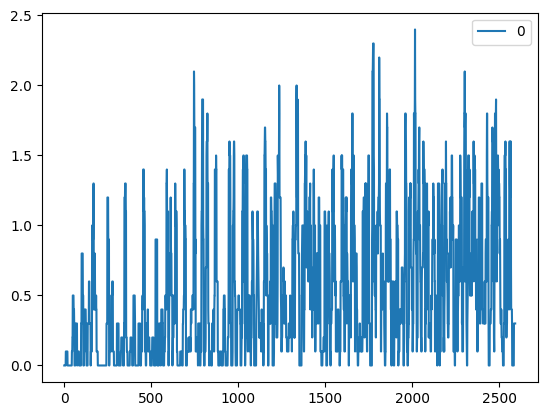

In [17]:
pgn = R.learn(iters=100)

#### Umsetzung
- Es gibt zwei wählbare Modelle
- Das lineare Modell bildet den Zustand (8,8,8) auf die Aktionen (64,64) ab, was über 32k trainierbare Gewichte ergibt, dies ist sehr ineffizient.
- Das konvolutionelle Modell verwendet 2 1x1 Konvolutionen und nimmt das äußere Produkt der resultierenden Arrays. Dies ergibt nur 18 trainierbare Gewichte
    - Vorteil:  schnellere Konvergenz
    - Nachteil: Informationen gehen verloren -> geringere Leistung
- Für eine echte Schach-KI benötigen wir größere neuronale Netzwerke.

<Axes: title={'center': 'average performance over the last 125 steps'}>

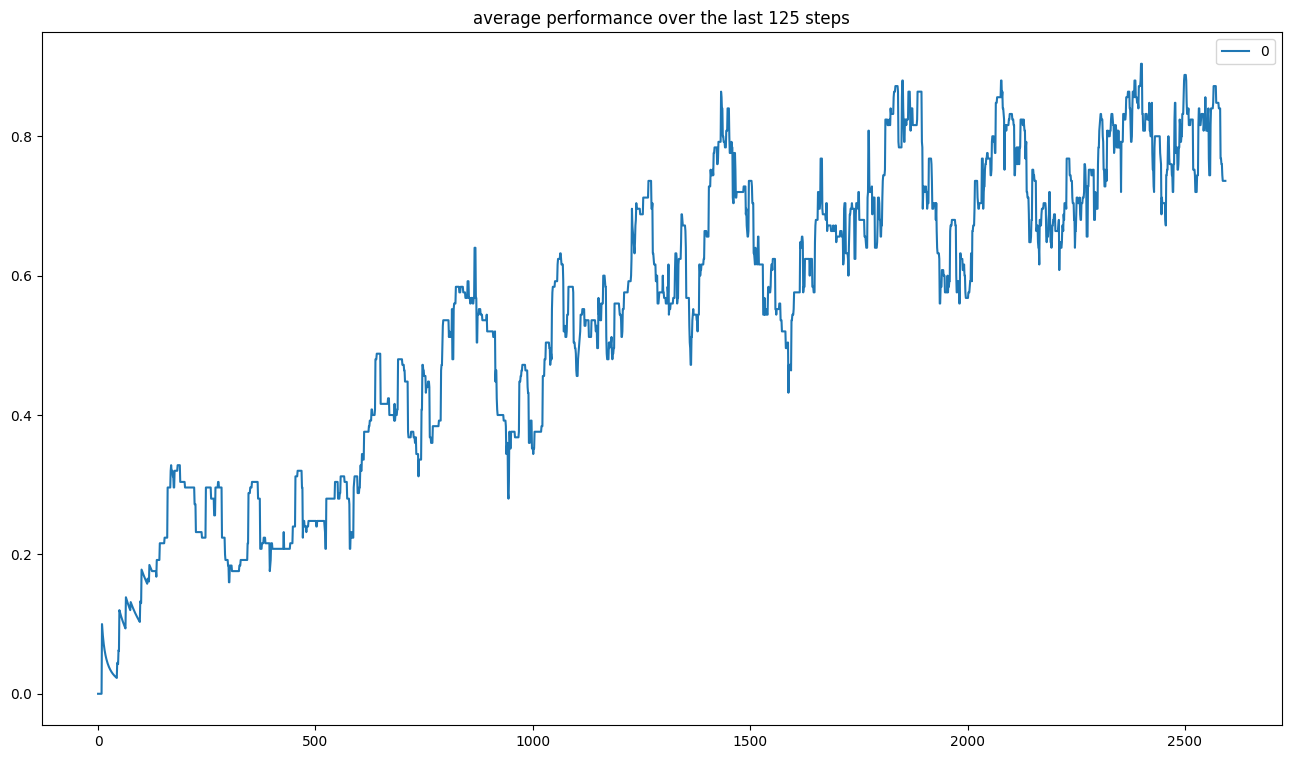

In [18]:
reward_smooth = pd.DataFrame(R.reward_trace)
reward_smooth.rolling(window=125,min_periods=0).mean().plot(figsize=(16,9),title='average performance over the last 125 steps')

#### Auswertung der Ergebnisse

In [15]:
with open("final_game.pgn","w") as log:
    log.write(str(pgn))

Die Ausgabe des letzen Spiels, dies kann beispielsweise über [chess.com](https://www.chess.com/analysis) eingelesen werden.

## Referenzen
Reinforcement Learning: An Introduction  
> Richard S. Sutton and Andrew G. Barto  
> 1st Edition  
> MIT Press, march 1998  

RL Kurs von David Silver: Lecture playlist  
> https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ  

Experience Replay  
> https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits